In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm, tqdm_notebook
from tqdm import trange
import time

In [4]:
AAA=np.load('SFA_Skin_RGBCBCR.npy')
BBB=np.load('SFA_NSkin_RGBCBCR.npy')

In [5]:
input_data=[]
for i in range(2):
    if i == 0:
        for j in range(len(AAA)):
            input_data.append(AAA[j])
    else :
        for j in range(len(BBB)):
            input_data.append(BBB[j])

In [6]:
label=[]
for i in range(len(AAA)+len(BBB)):
    if i>=len(AAA):
        label.append(0)
    else:
        label.append(1)

In [7]:
label=np.array(label)
input_data=np.array(input_data)

In [8]:
input_data= (input_data*(1/256)-0.5)/0.5

In [9]:
input_data=torch.FloatTensor(input_data)
label=torch.LongTensor(label)

In [10]:
input_data.shape

torch.Size([2584816, 5])

In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
dataset = TensorDataset(input_data,label)

In [12]:
trainset,valset=torch.utils.data.random_split(dataset,[1809416,775400])
trainset,testset=torch.utils.data.random_split(trainset,[1034016,775400])

partition={'train':trainset,'val':valset,'test':testset}

In [13]:
class MLP(nn.Module):
    
    def __init__(self,hid_dim,hid_dim1,act):
        super(MLP,self).__init__()
        self.act = act
        self.hid_dim=hid_dim
        self.hid_dim1=hid_dim1
        
        if self.act =='ReLU':
            self.act = nn.ReLU()
        elif self.act == 'Tanh':
            self.act = nn.Tanh()
        elif self.act == 'Sigmoid':
            self.act = nn.Sigmoid()
        else :
            raise ValueError('no valid activation function selected!')
        if self.hid_dim1 == 0:
            self.models=nn.Sequential(
                nn.Linear(5,self.hid_dim),
                self.act,
                nn.Linear(self.hid_dim,2),
            )
        else :
            self.models=nn.Sequential(
                nn.Linear(5,self.hid_dim),
                self.act,
                nn.Linear(self.hid_dim,self.hid_dim1),
                self.act,
                nn.Linear(self.hid_dim1,2),
            )
    def forward(self,x):
        x=self.models(x)
        return x

In [23]:
def train(net,partition,optimizer,criterion):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                             batch_size=4096,
                                             shuffle=True)
    net.train()
    correct = 0
    total =0
    train_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, 0)):
        time.sleep(0.0000001)
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #if i % 200 == 0:
        #    print(correct,train_loss)
    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [15]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=4096, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [16]:
def validate(net, partition, criterion):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=4096, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in tqdm(valloader):
            time.sleep(0.0000001)
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [27]:
def experiment(partition, args):
    net=MLP(args.hid_dim,args.hid_dim1,'ReLU')
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0015, weight_decay=0.00001)
    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]
    for epoch in range(args.epoch):
        ts=time.time()
        net, train_loss,train_acc=train(net, partition, optimizer, criterion)
        val_loss, val_acc = validate(net, partition, criterion)
        te=time.time()
        print('time : {:2.2f}, train_loss : {:2.2f}, train_acc : {:2.2f},val_acc : {:2.2f},val_loss : {:2.2f}'.format(te-ts,train_loss,train_acc,val_acc,val_loss))

        train_loss=round(train_loss,2)#리스트에 넣기 위해 3번째 자릿수 반올림
        val_loss=round(val_loss,2)
        train_acc=round(train_acc,2)
        val_acc=round(val_acc,2)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)    


    torch.save(net,'/home/lab/양창희/pytorch/Skin_MLP/model/model_h_{}h1_{}.pt'.format(args.hid_dim,args.hid_dim1))
    test_acc = test(net,partition,criterion)
    test_acc=round(test_acc,2)
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [30]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']# epoch값에 따라 파일이 여러개 생김.
    #del setting['test_batch_size']# 실험에 영향이 없기 때문에

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting) # uodate는 딕셔너리를 합치는거임.
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [31]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp_hid"
args.epoch = 20
name_var1='hid_dim'
name_var2='hid_dim1'
list_var1=[3,4,5,6]
list_var2=[3,4,5,6]
for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) #args.name_var1 = var1
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

  0%|          | 1/253 [00:00<00:32,  7.76it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=3, hid_dim1=3)


  1%|          | 2/253 [00:00<00:13, 18.90it/s]

time : 13.31, train_loss : 0.60, train_acc : 59.57,val_acc : 71.81,val_loss : 0.48


  1%|          | 2/253 [00:00<00:13, 19.00it/s]

time : 12.80, train_loss : 0.41, train_acc : 80.60,val_acc : 83.58,val_loss : 0.36


  0%|          | 1/253 [00:00<00:42,  5.90it/s]

time : 13.09, train_loss : 0.34, train_acc : 85.24,val_acc : 88.97,val_loss : 0.29


  1%|          | 2/253 [00:00<00:16, 15.02it/s]

time : 13.24, train_loss : 0.23, train_acc : 92.29,val_acc : 92.69,val_loss : 0.21


  1%|          | 2/253 [00:00<00:16, 15.05it/s]

time : 13.29, train_loss : 0.20, train_acc : 92.83,val_acc : 92.87,val_loss : 0.20


  0%|          | 1/253 [00:00<00:37,  6.78it/s]

time : 12.94, train_loss : 0.19, train_acc : 92.98,val_acc : 93.03,val_loss : 0.19


  1%|          | 2/253 [00:00<00:16, 15.28it/s]

time : 13.33, train_loss : 0.19, train_acc : 93.14,val_acc : 93.19,val_loss : 0.18


  1%|          | 2/253 [00:00<00:16, 15.55it/s]

time : 13.32, train_loss : 0.18, train_acc : 93.32,val_acc : 93.40,val_loss : 0.18


  0%|          | 1/253 [00:00<00:43,  5.79it/s]

time : 12.88, train_loss : 0.17, train_acc : 93.53,val_acc : 93.59,val_loss : 0.17


  1%|          | 2/253 [00:00<00:16, 15.01it/s]

time : 13.26, train_loss : 0.17, train_acc : 93.76,val_acc : 93.85,val_loss : 0.17


  1%|          | 2/253 [00:00<00:13, 18.97it/s]

time : 13.25, train_loss : 0.16, train_acc : 94.00,val_acc : 94.10,val_loss : 0.16


  1%|          | 2/253 [00:00<00:20, 12.00it/s]

time : 13.17, train_loss : 0.16, train_acc : 94.30,val_acc : 94.44,val_loss : 0.15


  1%|          | 2/253 [00:00<00:16, 14.97it/s]

time : 13.19, train_loss : 0.15, train_acc : 94.59,val_acc : 94.66,val_loss : 0.15


  1%|          | 2/253 [00:00<00:16, 14.91it/s]

time : 13.08, train_loss : 0.14, train_acc : 94.83,val_acc : 94.84,val_loss : 0.14


  1%|          | 2/253 [00:00<00:24, 10.30it/s]

time : 13.36, train_loss : 0.14, train_acc : 94.97,val_acc : 94.96,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 19.08it/s]

time : 12.88, train_loss : 0.14, train_acc : 95.01,val_acc : 94.95,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.95it/s]

time : 12.90, train_loss : 0.14, train_acc : 95.02,val_acc : 94.97,val_loss : 0.14


  1%|          | 2/253 [00:00<00:23, 10.75it/s]

time : 13.03, train_loss : 0.14, train_acc : 95.02,val_acc : 94.97,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 14.79it/s]

time : 13.28, train_loss : 0.14, train_acc : 95.03,val_acc : 95.01,val_loss : 0.14


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.38, train_loss : 0.14, train_acc : 95.04,val_acc : 95.00,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.26it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=3, hid_dim1=4)


  1%|          | 2/253 [00:00<00:21, 11.66it/s]

time : 13.36, train_loss : 0.55, train_acc : 70.99,val_acc : 86.65,val_loss : 0.35


  1%|          | 2/253 [00:00<00:13, 19.11it/s]

time : 13.18, train_loss : 0.24, train_acc : 91.49,val_acc : 92.74,val_loss : 0.19


  0%|          | 1/253 [00:00<00:39,  6.38it/s]

time : 13.22, train_loss : 0.19, train_acc : 92.97,val_acc : 93.16,val_loss : 0.18


  1%|          | 2/253 [00:00<00:13, 18.77it/s]

time : 13.11, train_loss : 0.18, train_acc : 93.36,val_acc : 93.51,val_loss : 0.17


  1%|          | 2/253 [00:00<00:15, 16.50it/s]

time : 13.36, train_loss : 0.17, train_acc : 93.78,val_acc : 94.14,val_loss : 0.16


  0%|          | 1/253 [00:00<00:43,  5.81it/s]

time : 13.15, train_loss : 0.15, train_acc : 94.58,val_acc : 94.81,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.82it/s]

time : 13.34, train_loss : 0.14, train_acc : 94.99,val_acc : 95.04,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.07it/s]

time : 13.22, train_loss : 0.14, train_acc : 95.12,val_acc : 95.14,val_loss : 0.13


  0%|          | 1/253 [00:00<00:35,  7.14it/s]

time : 13.60, train_loss : 0.13, train_acc : 95.19,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.31it/s]

time : 13.58, train_loss : 0.13, train_acc : 95.26,val_acc : 95.26,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.54it/s]

time : 13.16, train_loss : 0.13, train_acc : 95.33,val_acc : 95.33,val_loss : 0.13


  0%|          | 1/253 [00:00<00:37,  6.76it/s]

time : 13.24, train_loss : 0.13, train_acc : 95.36,val_acc : 95.31,val_loss : 0.13


  1%|          | 2/253 [00:00<00:12, 19.75it/s]

time : 13.05, train_loss : 0.13, train_acc : 95.36,val_acc : 95.33,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 19.05it/s]

time : 13.50, train_loss : 0.13, train_acc : 95.39,val_acc : 95.35,val_loss : 0.13


  0%|          | 1/253 [00:00<00:33,  7.51it/s]

time : 13.05, train_loss : 0.13, train_acc : 95.39,val_acc : 95.34,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 19.19it/s]

time : 13.05, train_loss : 0.13, train_acc : 95.41,val_acc : 95.36,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.83it/s]

time : 13.05, train_loss : 0.13, train_acc : 95.44,val_acc : 95.40,val_loss : 0.13


  1%|          | 2/253 [00:00<00:24, 10.24it/s]

time : 13.34, train_loss : 0.13, train_acc : 95.47,val_acc : 95.45,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.07it/s]

time : 13.02, train_loss : 0.12, train_acc : 95.50,val_acc : 95.48,val_loss : 0.12


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.06, train_loss : 0.12, train_acc : 95.51,val_acc : 95.46,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 19.01it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=3, hid_dim1=5)


  1%|          | 2/253 [00:00<00:20, 12.01it/s]

time : 13.27, train_loss : 0.54, train_acc : 72.10,val_acc : 90.14,val_loss : 0.29


  1%|          | 2/253 [00:00<00:16, 14.78it/s]

time : 13.11, train_loss : 0.23, train_acc : 91.80,val_acc : 92.82,val_loss : 0.20


  1%|          | 2/253 [00:00<00:16, 15.55it/s]

time : 12.98, train_loss : 0.19, train_acc : 93.22,val_acc : 93.48,val_loss : 0.18


  1%|          | 2/253 [00:00<00:21, 11.88it/s]

time : 13.14, train_loss : 0.17, train_acc : 93.74,val_acc : 94.00,val_loss : 0.17


  1%|          | 2/253 [00:00<00:16, 14.91it/s]

time : 13.26, train_loss : 0.16, train_acc : 94.14,val_acc : 94.22,val_loss : 0.16


  1%|          | 2/253 [00:00<00:13, 18.61it/s]

time : 13.41, train_loss : 0.15, train_acc : 94.40,val_acc : 94.44,val_loss : 0.15


  0%|          | 0/253 [00:00<?, ?it/s]

time : 13.13, train_loss : 0.15, train_acc : 94.57,val_acc : 94.54,val_loss : 0.15


  1%|          | 2/253 [00:00<00:16, 15.04it/s]

time : 13.33, train_loss : 0.15, train_acc : 94.72,val_acc : 94.72,val_loss : 0.15


  1%|          | 2/253 [00:00<00:16, 15.05it/s]

time : 13.06, train_loss : 0.15, train_acc : 94.82,val_acc : 94.78,val_loss : 0.15


  1%|          | 2/253 [00:00<00:21, 11.77it/s]

time : 13.18, train_loss : 0.14, train_acc : 94.88,val_acc : 94.87,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.97it/s]

time : 13.34, train_loss : 0.14, train_acc : 94.90,val_acc : 94.87,val_loss : 0.14


  0%|          | 1/253 [00:00<00:42,  5.91it/s]

time : 13.25, train_loss : 0.14, train_acc : 94.90,val_acc : 94.90,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.25it/s]

time : 13.39, train_loss : 0.14, train_acc : 94.92,val_acc : 94.89,val_loss : 0.14


  1%|          | 2/253 [00:00<00:17, 14.69it/s]

time : 13.00, train_loss : 0.14, train_acc : 94.92,val_acc : 94.90,val_loss : 0.14


  0%|          | 1/253 [00:00<00:36,  6.94it/s]

time : 12.96, train_loss : 0.14, train_acc : 94.93,val_acc : 94.90,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.86it/s]

time : 13.44, train_loss : 0.14, train_acc : 94.93,val_acc : 94.91,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 19.16it/s]

time : 13.06, train_loss : 0.14, train_acc : 94.93,val_acc : 94.92,val_loss : 0.14


  0%|          | 1/253 [00:00<00:42,  5.92it/s]

time : 13.06, train_loss : 0.14, train_acc : 94.94,val_acc : 94.89,val_loss : 0.14


  1%|          | 2/253 [00:00<00:17, 14.46it/s]

time : 13.20, train_loss : 0.14, train_acc : 94.93,val_acc : 94.86,val_loss : 0.14


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.18, train_loss : 0.14, train_acc : 94.94,val_acc : 94.93,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.14it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=3, hid_dim1=6)


  0%|          | 1/253 [00:00<00:33,  7.51it/s]

time : 13.29, train_loss : 0.56, train_acc : 68.47,val_acc : 80.92,val_loss : 0.40


  1%|          | 2/253 [00:00<00:12, 19.33it/s]

time : 13.24, train_loss : 0.30, train_acc : 87.75,val_acc : 91.49,val_loss : 0.23


  1%|          | 2/253 [00:00<00:16, 15.04it/s]

time : 13.32, train_loss : 0.22, train_acc : 91.96,val_acc : 92.15,val_loss : 0.22


  1%|          | 2/253 [00:00<00:22, 11.34it/s]

time : 13.13, train_loss : 0.21, train_acc : 92.32,val_acc : 92.39,val_loss : 0.21


  1%|          | 2/253 [00:00<00:16, 15.23it/s]

time : 13.08, train_loss : 0.21, train_acc : 92.50,val_acc : 92.57,val_loss : 0.21


  1%|          | 2/253 [00:00<00:16, 14.97it/s]

time : 13.13, train_loss : 0.20, train_acc : 92.69,val_acc : 92.82,val_loss : 0.20


  1%|          | 2/253 [00:00<00:20, 12.20it/s]

time : 13.27, train_loss : 0.19, train_acc : 93.11,val_acc : 93.34,val_loss : 0.18


  1%|          | 2/253 [00:00<00:13, 19.09it/s]

time : 13.08, train_loss : 0.17, train_acc : 93.76,val_acc : 94.08,val_loss : 0.17


  1%|          | 2/253 [00:00<00:15, 15.79it/s]

time : 13.29, train_loss : 0.16, train_acc : 94.28,val_acc : 94.43,val_loss : 0.16


  1%|          | 2/253 [00:00<00:20, 12.01it/s]

time : 12.98, train_loss : 0.15, train_acc : 94.52,val_acc : 94.64,val_loss : 0.15


  1%|          | 2/253 [00:00<00:17, 14.08it/s]

time : 13.28, train_loss : 0.15, train_acc : 94.66,val_acc : 94.68,val_loss : 0.15


  1%|          | 2/253 [00:00<00:13, 18.94it/s]

time : 13.47, train_loss : 0.14, train_acc : 94.73,val_acc : 94.70,val_loss : 0.14


  0%|          | 0/253 [00:00<?, ?it/s]

time : 13.37, train_loss : 0.14, train_acc : 94.77,val_acc : 94.76,val_loss : 0.14


  1%|          | 2/253 [00:00<00:12, 19.96it/s]

time : 13.26, train_loss : 0.14, train_acc : 94.81,val_acc : 94.83,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.31it/s]

time : 12.87, train_loss : 0.14, train_acc : 94.84,val_acc : 94.85,val_loss : 0.14


  1%|          | 2/253 [00:00<00:22, 11.20it/s]

time : 13.36, train_loss : 0.14, train_acc : 94.87,val_acc : 94.87,val_loss : 0.14


  1%|          | 2/253 [00:00<00:14, 17.92it/s]

time : 13.19, train_loss : 0.14, train_acc : 94.89,val_acc : 94.88,val_loss : 0.14


  0%|          | 1/253 [00:00<00:34,  7.22it/s]

time : 13.14, train_loss : 0.14, train_acc : 94.91,val_acc : 94.90,val_loss : 0.14


  1%|          | 2/253 [00:00<00:12, 19.76it/s]

time : 13.27, train_loss : 0.14, train_acc : 94.92,val_acc : 94.92,val_loss : 0.14


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.16, train_loss : 0.14, train_acc : 94.93,val_acc : 94.96,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 19.23it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=4, hid_dim1=3)


  0%|          | 1/253 [00:00<00:42,  5.99it/s]

time : 12.89, train_loss : 0.54, train_acc : 66.12,val_acc : 89.87,val_loss : 0.29


  1%|          | 2/253 [00:00<00:13, 18.71it/s]

time : 13.43, train_loss : 0.25, train_acc : 91.30,val_acc : 91.80,val_loss : 0.23


  1%|          | 2/253 [00:00<00:13, 19.12it/s]

time : 13.04, train_loss : 0.22, train_acc : 92.10,val_acc : 92.21,val_loss : 0.22


  0%|          | 1/253 [00:00<00:32,  7.72it/s]

time : 12.97, train_loss : 0.22, train_acc : 92.33,val_acc : 92.35,val_loss : 0.21


  1%|          | 2/253 [00:00<00:13, 18.98it/s]

time : 13.26, train_loss : 0.21, train_acc : 92.50,val_acc : 92.46,val_loss : 0.21


  1%|          | 2/253 [00:00<00:13, 18.84it/s]

time : 13.27, train_loss : 0.20, train_acc : 92.67,val_acc : 92.71,val_loss : 0.20


  0%|          | 1/253 [00:00<00:33,  7.62it/s]

time : 13.42, train_loss : 0.19, train_acc : 92.91,val_acc : 93.01,val_loss : 0.19


  1%|          | 2/253 [00:00<00:17, 14.73it/s]

time : 13.17, train_loss : 0.18, train_acc : 93.30,val_acc : 93.54,val_loss : 0.17


  1%|          | 2/253 [00:00<00:12, 19.49it/s]

time : 13.55, train_loss : 0.16, train_acc : 94.00,val_acc : 94.31,val_loss : 0.16


  1%|          | 2/253 [00:00<00:20, 12.32it/s]

time : 13.18, train_loss : 0.15, train_acc : 94.60,val_acc : 94.74,val_loss : 0.15


  1%|          | 2/253 [00:00<00:13, 18.28it/s]

time : 12.93, train_loss : 0.15, train_acc : 94.84,val_acc : 94.87,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 14.97it/s]

time : 13.49, train_loss : 0.14, train_acc : 94.92,val_acc : 94.90,val_loss : 0.14


  1%|          | 2/253 [00:00<00:20, 12.14it/s]

time : 13.34, train_loss : 0.14, train_acc : 94.95,val_acc : 94.90,val_loss : 0.14


  1%|          | 2/253 [00:00<00:15, 15.79it/s]

time : 13.35, train_loss : 0.14, train_acc : 94.96,val_acc : 94.89,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 14.78it/s]

time : 13.01, train_loss : 0.14, train_acc : 94.96,val_acc : 94.94,val_loss : 0.14


  1%|          | 2/253 [00:00<00:20, 12.15it/s]

time : 13.22, train_loss : 0.14, train_acc : 94.96,val_acc : 94.93,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.75it/s]

time : 13.03, train_loss : 0.14, train_acc : 94.96,val_acc : 94.92,val_loss : 0.14


  1%|          | 2/253 [00:00<00:15, 15.94it/s]

time : 13.05, train_loss : 0.14, train_acc : 94.97,val_acc : 94.92,val_loss : 0.14


  1%|          | 2/253 [00:00<00:23, 10.60it/s]

time : 12.98, train_loss : 0.14, train_acc : 94.97,val_acc : 94.92,val_loss : 0.14


  0%|          | 0/190 [00:00<?, ?it/s]

time : 12.95, train_loss : 0.14, train_acc : 94.98,val_acc : 94.95,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.30it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=4, hid_dim1=4)


  1%|          | 2/253 [00:00<00:14, 17.12it/s]

time : 13.12, train_loss : 0.56, train_acc : 66.34,val_acc : 85.77,val_loss : 0.38


  1%|          | 2/253 [00:00<00:24, 10.36it/s]

time : 12.93, train_loss : 0.29, train_acc : 90.67,val_acc : 92.66,val_loss : 0.23


  1%|          | 2/253 [00:00<00:16, 15.33it/s]

time : 13.13, train_loss : 0.21, train_acc : 93.03,val_acc : 93.27,val_loss : 0.20


  0%|          | 1/253 [00:00<00:32,  7.69it/s]

time : 13.22, train_loss : 0.19, train_acc : 93.58,val_acc : 93.79,val_loss : 0.18


  1%|          | 2/253 [00:00<00:16, 15.29it/s]

time : 13.22, train_loss : 0.17, train_acc : 94.09,val_acc : 94.33,val_loss : 0.16


  1%|          | 2/253 [00:00<00:13, 18.59it/s]

time : 13.06, train_loss : 0.16, train_acc : 94.55,val_acc : 94.74,val_loss : 0.15


  0%|          | 1/253 [00:00<00:32,  7.66it/s]

time : 13.34, train_loss : 0.15, train_acc : 94.91,val_acc : 95.00,val_loss : 0.15


  1%|          | 2/253 [00:00<00:14, 17.00it/s]

time : 13.21, train_loss : 0.14, train_acc : 95.11,val_acc : 95.14,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.37it/s]

time : 13.19, train_loss : 0.14, train_acc : 95.23,val_acc : 95.27,val_loss : 0.13


  0%|          | 1/253 [00:00<00:34,  7.34it/s]

time : 13.22, train_loss : 0.13, train_acc : 95.37,val_acc : 95.47,val_loss : 0.13


  1%|          | 2/253 [00:00<00:17, 14.72it/s]

time : 12.87, train_loss : 0.13, train_acc : 95.50,val_acc : 95.52,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.75it/s]

time : 13.13, train_loss : 0.13, train_acc : 95.54,val_acc : 95.56,val_loss : 0.13


  0%|          | 1/253 [00:00<00:41,  6.05it/s]

time : 13.37, train_loss : 0.12, train_acc : 95.58,val_acc : 95.59,val_loss : 0.12


  1%|          | 2/253 [00:00<00:14, 17.20it/s]

time : 13.06, train_loss : 0.12, train_acc : 95.60,val_acc : 95.61,val_loss : 0.12


  1%|          | 2/253 [00:00<00:15, 16.65it/s]

time : 12.95, train_loss : 0.12, train_acc : 95.61,val_acc : 95.60,val_loss : 0.12


  0%|          | 1/253 [00:00<00:33,  7.46it/s]

time : 13.20, train_loss : 0.12, train_acc : 95.61,val_acc : 95.61,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 19.12it/s]

time : 12.86, train_loss : 0.12, train_acc : 95.62,val_acc : 95.60,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 14.87it/s]

time : 13.38, train_loss : 0.12, train_acc : 95.62,val_acc : 95.58,val_loss : 0.12


  1%|          | 2/253 [00:00<00:24, 10.41it/s]

time : 13.56, train_loss : 0.12, train_acc : 95.63,val_acc : 95.60,val_loss : 0.12


  0%|          | 0/190 [00:00<?, ?it/s]

time : 12.91, train_loss : 0.12, train_acc : 95.63,val_acc : 95.62,val_loss : 0.12


  1%|          | 2/253 [00:00<00:15, 15.74it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=4, hid_dim1=5)


  1%|          | 2/253 [00:00<00:13, 18.01it/s]

time : 13.07, train_loss : 0.55, train_acc : 68.67,val_acc : 86.13,val_loss : 0.38


  1%|          | 2/253 [00:00<00:23, 10.61it/s]

time : 13.38, train_loss : 0.28, train_acc : 90.68,val_acc : 92.56,val_loss : 0.23


  1%|          | 2/253 [00:00<00:13, 18.80it/s]

time : 13.31, train_loss : 0.21, train_acc : 93.09,val_acc : 93.35,val_loss : 0.19


  1%|          | 2/253 [00:00<00:13, 18.79it/s]

time : 12.97, train_loss : 0.18, train_acc : 93.61,val_acc : 93.78,val_loss : 0.18


  1%|          | 2/253 [00:00<00:24, 10.05it/s]

time : 13.34, train_loss : 0.17, train_acc : 93.99,val_acc : 94.07,val_loss : 0.17


  1%|          | 2/253 [00:00<00:16, 15.18it/s]

time : 12.97, train_loss : 0.16, train_acc : 94.22,val_acc : 94.26,val_loss : 0.16


  1%|          | 2/253 [00:00<00:13, 19.13it/s]

time : 13.09, train_loss : 0.15, train_acc : 94.43,val_acc : 94.49,val_loss : 0.15


  1%|          | 2/253 [00:00<00:20, 12.28it/s]

time : 13.13, train_loss : 0.15, train_acc : 94.69,val_acc : 94.75,val_loss : 0.14


  1%|          | 2/253 [00:00<00:14, 17.71it/s]

time : 13.08, train_loss : 0.14, train_acc : 94.92,val_acc : 94.93,val_loss : 0.14


  0%|          | 1/253 [00:00<00:33,  7.43it/s]

time : 13.44, train_loss : 0.14, train_acc : 95.03,val_acc : 95.00,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.88it/s]

time : 13.59, train_loss : 0.14, train_acc : 95.09,val_acc : 95.05,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.97it/s]

time : 13.24, train_loss : 0.13, train_acc : 95.12,val_acc : 95.08,val_loss : 0.13


  0%|          | 1/253 [00:00<00:37,  6.76it/s]

time : 12.90, train_loss : 0.13, train_acc : 95.15,val_acc : 95.12,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 19.30it/s]

time : 13.21, train_loss : 0.13, train_acc : 95.18,val_acc : 95.14,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.01it/s]

time : 13.03, train_loss : 0.13, train_acc : 95.20,val_acc : 95.19,val_loss : 0.13


  0%|          | 1/253 [00:00<00:35,  7.07it/s]

time : 13.55, train_loss : 0.13, train_acc : 95.24,val_acc : 95.23,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 19.01it/s]

time : 13.24, train_loss : 0.13, train_acc : 95.27,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 19.28it/s]

time : 12.98, train_loss : 0.13, train_acc : 95.30,val_acc : 95.25,val_loss : 0.13


  0%|          | 1/253 [00:00<00:38,  6.48it/s]

time : 13.26, train_loss : 0.13, train_acc : 95.32,val_acc : 95.28,val_loss : 0.13


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.50, train_loss : 0.13, train_acc : 95.34,val_acc : 95.31,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.00it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=4, hid_dim1=6)


  1%|          | 2/253 [00:00<00:13, 18.89it/s]

time : 13.73, train_loss : 0.54, train_acc : 69.33,val_acc : 88.66,val_loss : 0.34


  0%|          | 1/253 [00:00<00:36,  6.87it/s]

time : 12.99, train_loss : 0.24, train_acc : 91.91,val_acc : 92.98,val_loss : 0.19


  1%|          | 2/253 [00:00<00:16, 15.26it/s]

time : 12.99, train_loss : 0.18, train_acc : 93.39,val_acc : 93.66,val_loss : 0.17


  1%|          | 2/253 [00:00<00:17, 14.64it/s]

time : 13.29, train_loss : 0.16, train_acc : 93.96,val_acc : 94.16,val_loss : 0.16


  1%|          | 2/253 [00:00<00:20, 12.49it/s]

time : 13.49, train_loss : 0.15, train_acc : 94.41,val_acc : 94.55,val_loss : 0.15


  1%|          | 2/253 [00:00<00:12, 19.32it/s]

time : 13.04, train_loss : 0.15, train_acc : 94.67,val_acc : 94.71,val_loss : 0.14


  1%|          | 2/253 [00:00<00:14, 17.01it/s]

time : 12.92, train_loss : 0.14, train_acc : 94.82,val_acc : 94.82,val_loss : 0.14


  1%|          | 2/253 [00:00<00:21, 11.73it/s]

time : 12.98, train_loss : 0.14, train_acc : 94.91,val_acc : 94.89,val_loss : 0.14


  1%|          | 2/253 [00:00<00:14, 17.69it/s]

time : 13.38, train_loss : 0.14, train_acc : 94.98,val_acc : 94.93,val_loss : 0.14


  1%|          | 2/253 [00:00<00:12, 19.49it/s]

time : 12.92, train_loss : 0.14, train_acc : 95.04,val_acc : 94.96,val_loss : 0.14


  0%|          | 0/253 [00:00<?, ?it/s]

time : 13.43, train_loss : 0.14, train_acc : 95.06,val_acc : 95.00,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 14.91it/s]

time : 13.20, train_loss : 0.14, train_acc : 95.08,val_acc : 95.02,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 14.90it/s]

time : 13.21, train_loss : 0.13, train_acc : 95.09,val_acc : 95.06,val_loss : 0.13


  1%|          | 2/253 [00:00<00:24, 10.42it/s]

time : 13.07, train_loss : 0.13, train_acc : 95.11,val_acc : 95.06,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.24it/s]

time : 13.28, train_loss : 0.13, train_acc : 95.12,val_acc : 95.08,val_loss : 0.13


  0%|          | 1/253 [00:00<00:38,  6.63it/s]

time : 13.31, train_loss : 0.13, train_acc : 95.13,val_acc : 95.07,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 19.08it/s]

time : 13.18, train_loss : 0.13, train_acc : 95.13,val_acc : 95.09,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.73it/s]

time : 13.41, train_loss : 0.13, train_acc : 95.13,val_acc : 95.09,val_loss : 0.13


  0%|          | 1/253 [00:00<00:34,  7.25it/s]

time : 13.08, train_loss : 0.13, train_acc : 95.18,val_acc : 95.17,val_loss : 0.13


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.25, train_loss : 0.13, train_acc : 95.22,val_acc : 95.23,val_loss : 0.13


  1%|          | 2/253 [00:00<00:12, 19.52it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=5, hid_dim1=3)


  1%|          | 2/253 [00:00<00:15, 15.69it/s]

time : 13.60, train_loss : 0.62, train_acc : 62.55,val_acc : 62.47,val_loss : 0.46


  0%|          | 1/253 [00:00<00:34,  7.26it/s]

time : 13.24, train_loss : 0.31, train_acc : 89.39,val_acc : 93.03,val_loss : 0.24


  1%|          | 2/253 [00:00<00:14, 17.54it/s]

time : 13.44, train_loss : 0.21, train_acc : 93.47,val_acc : 93.74,val_loss : 0.20


  1%|          | 2/253 [00:00<00:13, 18.63it/s]

time : 13.33, train_loss : 0.18, train_acc : 93.98,val_acc : 94.14,val_loss : 0.18


  0%|          | 1/253 [00:00<00:38,  6.52it/s]

time : 13.42, train_loss : 0.17, train_acc : 94.34,val_acc : 94.49,val_loss : 0.16


  1%|          | 2/253 [00:00<00:13, 18.68it/s]

time : 13.22, train_loss : 0.15, train_acc : 94.73,val_acc : 94.89,val_loss : 0.15


  1%|          | 2/253 [00:00<00:16, 15.31it/s]

time : 13.49, train_loss : 0.14, train_acc : 95.10,val_acc : 95.17,val_loss : 0.14


  0%|          | 1/253 [00:00<00:35,  7.13it/s]

time : 13.08, train_loss : 0.14, train_acc : 95.26,val_acc : 95.29,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.74it/s]

time : 13.64, train_loss : 0.13, train_acc : 95.41,val_acc : 95.46,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.23it/s]

time : 13.35, train_loss : 0.13, train_acc : 95.51,val_acc : 95.49,val_loss : 0.13


  1%|          | 2/253 [00:00<00:20, 12.35it/s]

time : 13.27, train_loss : 0.13, train_acc : 95.54,val_acc : 95.53,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 14.93it/s]

time : 13.06, train_loss : 0.12, train_acc : 95.56,val_acc : 95.58,val_loss : 0.12


  1%|          | 2/253 [00:00<00:12, 19.38it/s]

time : 13.31, train_loss : 0.12, train_acc : 95.61,val_acc : 95.62,val_loss : 0.12


  1%|          | 2/253 [00:00<00:24, 10.37it/s]

time : 12.93, train_loss : 0.12, train_acc : 95.68,val_acc : 95.69,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 15.02it/s]

time : 13.00, train_loss : 0.12, train_acc : 95.72,val_acc : 95.73,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 15.27it/s]

time : 13.29, train_loss : 0.12, train_acc : 95.76,val_acc : 95.75,val_loss : 0.12


  0%|          | 0/253 [00:00<?, ?it/s]

time : 13.17, train_loss : 0.12, train_acc : 95.78,val_acc : 95.76,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 15.33it/s]

time : 13.33, train_loss : 0.12, train_acc : 95.79,val_acc : 95.78,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 18.76it/s]

time : 12.95, train_loss : 0.12, train_acc : 95.80,val_acc : 95.78,val_loss : 0.12


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.30, train_loss : 0.12, train_acc : 95.80,val_acc : 95.79,val_loss : 0.12


  1%|          | 2/253 [00:00<00:21, 11.73it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=5, hid_dim1=4)


  1%|          | 2/253 [00:00<00:12, 19.32it/s]

time : 13.20, train_loss : 0.55, train_acc : 68.90,val_acc : 79.46,val_loss : 0.42


  1%|          | 2/253 [00:00<00:16, 15.12it/s]

time : 13.11, train_loss : 0.39, train_acc : 81.33,val_acc : 82.54,val_loss : 0.37


  1%|          | 2/253 [00:00<00:25, 10.02it/s]

time : 13.20, train_loss : 0.36, train_acc : 83.40,val_acc : 84.59,val_loss : 0.34


  1%|          | 2/253 [00:00<00:13, 18.73it/s]

time : 13.02, train_loss : 0.29, train_acc : 88.02,val_acc : 91.43,val_loss : 0.22


  0%|          | 1/253 [00:00<00:34,  7.38it/s]

time : 13.36, train_loss : 0.22, train_acc : 91.67,val_acc : 91.84,val_loss : 0.21


  1%|          | 2/253 [00:00<00:13, 19.18it/s]

time : 13.41, train_loss : 0.21, train_acc : 92.03,val_acc : 92.17,val_loss : 0.21


  1%|          | 2/253 [00:00<00:15, 16.63it/s]

time : 13.36, train_loss : 0.21, train_acc : 92.25,val_acc : 92.30,val_loss : 0.21


  0%|          | 1/253 [00:00<00:33,  7.44it/s]

time : 13.44, train_loss : 0.20, train_acc : 92.40,val_acc : 92.46,val_loss : 0.20


  1%|          | 2/253 [00:00<00:15, 16.45it/s]

time : 13.28, train_loss : 0.19, train_acc : 92.83,val_acc : 94.04,val_loss : 0.17


  1%|          | 2/253 [00:00<00:16, 14.94it/s]

time : 12.93, train_loss : 0.16, train_acc : 94.30,val_acc : 94.44,val_loss : 0.15


  0%|          | 1/253 [00:00<00:33,  7.58it/s]

time : 13.09, train_loss : 0.15, train_acc : 94.58,val_acc : 94.69,val_loss : 0.15


  1%|          | 2/253 [00:00<00:13, 19.23it/s]

time : 12.86, train_loss : 0.15, train_acc : 94.80,val_acc : 94.89,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 14.88it/s]

time : 13.03, train_loss : 0.14, train_acc : 94.90,val_acc : 94.90,val_loss : 0.14


  0%|          | 1/253 [00:00<00:40,  6.16it/s]

time : 13.16, train_loss : 0.14, train_acc : 94.92,val_acc : 94.95,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.36it/s]

time : 12.94, train_loss : 0.14, train_acc : 94.92,val_acc : 94.92,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.46it/s]

time : 13.25, train_loss : 0.14, train_acc : 94.93,val_acc : 94.91,val_loss : 0.14


  1%|          | 2/253 [00:00<00:20, 12.11it/s]

time : 13.23, train_loss : 0.14, train_acc : 94.93,val_acc : 94.92,val_loss : 0.14


  1%|          | 2/253 [00:00<00:15, 16.59it/s]

time : 13.45, train_loss : 0.14, train_acc : 94.94,val_acc : 94.94,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.25it/s]

time : 13.03, train_loss : 0.14, train_acc : 94.94,val_acc : 94.94,val_loss : 0.14


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.45, train_loss : 0.14, train_acc : 94.96,val_acc : 94.95,val_loss : 0.14


  1%|          | 2/253 [00:00<00:24, 10.42it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=5, hid_dim1=5)


  1%|          | 2/253 [00:00<00:16, 15.16it/s]

time : 13.12, train_loss : 0.52, train_acc : 72.88,val_acc : 91.32,val_loss : 0.26


  1%|          | 2/253 [00:00<00:15, 15.99it/s]

time : 13.27, train_loss : 0.20, train_acc : 92.64,val_acc : 93.26,val_loss : 0.19


  0%|          | 0/253 [00:00<?, ?it/s]

time : 13.15, train_loss : 0.18, train_acc : 93.54,val_acc : 93.72,val_loss : 0.17


  1%|          | 2/253 [00:00<00:13, 18.58it/s]

time : 13.44, train_loss : 0.17, train_acc : 93.89,val_acc : 94.00,val_loss : 0.16


  1%|          | 2/253 [00:00<00:13, 18.90it/s]

time : 13.36, train_loss : 0.16, train_acc : 94.14,val_acc : 94.19,val_loss : 0.16


  1%|          | 2/253 [00:00<00:20, 12.39it/s]

time : 13.21, train_loss : 0.15, train_acc : 94.35,val_acc : 94.45,val_loss : 0.15


  1%|          | 2/253 [00:00<00:12, 19.68it/s]

time : 13.13, train_loss : 0.14, train_acc : 94.68,val_acc : 94.80,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.43it/s]

time : 13.38, train_loss : 0.14, train_acc : 95.01,val_acc : 95.09,val_loss : 0.13


  1%|          | 2/253 [00:00<00:24, 10.07it/s]

time : 13.13, train_loss : 0.13, train_acc : 95.18,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.64it/s]

time : 13.41, train_loss : 0.13, train_acc : 95.28,val_acc : 95.25,val_loss : 0.13


  0%|          | 1/253 [00:00<00:43,  5.76it/s]

time : 13.18, train_loss : 0.13, train_acc : 95.35,val_acc : 95.39,val_loss : 0.13


  1%|          | 2/253 [00:00<00:15, 16.03it/s]

time : 13.33, train_loss : 0.12, train_acc : 95.47,val_acc : 95.40,val_loss : 0.12


  1%|          | 2/253 [00:00<00:14, 17.61it/s]

time : 13.02, train_loss : 0.12, train_acc : 95.51,val_acc : 95.50,val_loss : 0.12


  0%|          | 1/253 [00:00<00:34,  7.26it/s]

time : 13.37, train_loss : 0.12, train_acc : 95.55,val_acc : 95.52,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 15.22it/s]

time : 13.28, train_loss : 0.12, train_acc : 95.57,val_acc : 95.55,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 14.87it/s]

time : 12.87, train_loss : 0.12, train_acc : 95.60,val_acc : 95.54,val_loss : 0.12


  0%|          | 1/253 [00:00<00:34,  7.40it/s]

time : 13.52, train_loss : 0.12, train_acc : 95.61,val_acc : 95.55,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 14.90it/s]

time : 13.28, train_loss : 0.12, train_acc : 95.63,val_acc : 95.60,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 14.91it/s]

time : 13.51, train_loss : 0.12, train_acc : 95.65,val_acc : 95.63,val_loss : 0.12


  0%|          | 0/190 [00:00<?, ?it/s]

time : 12.99, train_loss : 0.12, train_acc : 95.65,val_acc : 95.62,val_loss : 0.12


  0%|          | 1/253 [00:00<00:39,  6.45it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=5, hid_dim1=6)


  1%|          | 2/253 [00:00<00:13, 18.81it/s]

time : 13.49, train_loss : 0.60, train_acc : 73.92,val_acc : 92.23,val_loss : 0.41


  1%|          | 2/253 [00:00<00:12, 19.50it/s]

time : 13.12, train_loss : 0.32, train_acc : 93.06,val_acc : 93.38,val_loss : 0.27


  1%|          | 2/253 [00:00<00:20, 12.31it/s]

time : 13.39, train_loss : 0.24, train_acc : 93.66,val_acc : 93.88,val_loss : 0.22


  1%|          | 2/253 [00:00<00:16, 15.22it/s]

time : 13.38, train_loss : 0.18, train_acc : 94.10,val_acc : 94.31,val_loss : 0.16


  1%|          | 2/253 [00:00<00:13, 18.32it/s]

time : 13.19, train_loss : 0.15, train_acc : 94.54,val_acc : 94.69,val_loss : 0.14


  1%|          | 2/253 [00:00<00:20, 11.97it/s]

time : 13.38, train_loss : 0.14, train_acc : 94.85,val_acc : 94.87,val_loss : 0.14


  1%|          | 2/253 [00:00<00:12, 19.41it/s]

time : 13.22, train_loss : 0.14, train_acc : 94.97,val_acc : 94.99,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 19.09it/s]

time : 13.01, train_loss : 0.14, train_acc : 95.05,val_acc : 95.04,val_loss : 0.14


  0%|          | 0/253 [00:00<?, ?it/s]

time : 13.29, train_loss : 0.13, train_acc : 95.09,val_acc : 95.05,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.21it/s]

time : 13.07, train_loss : 0.13, train_acc : 95.12,val_acc : 95.11,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 14.97it/s]

time : 12.96, train_loss : 0.13, train_acc : 95.15,val_acc : 95.14,val_loss : 0.13


  1%|          | 2/253 [00:00<00:20, 12.24it/s]

time : 13.36, train_loss : 0.13, train_acc : 95.18,val_acc : 95.17,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.74it/s]

time : 13.14, train_loss : 0.13, train_acc : 95.19,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 14.88it/s]

time : 13.25, train_loss : 0.13, train_acc : 95.21,val_acc : 95.19,val_loss : 0.13


  1%|          | 2/253 [00:00<00:25,  9.98it/s]

time : 13.40, train_loss : 0.13, train_acc : 95.21,val_acc : 95.19,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.67it/s]

time : 13.03, train_loss : 0.13, train_acc : 95.22,val_acc : 95.20,val_loss : 0.13


  0%|          | 1/253 [00:00<00:41,  6.04it/s]

time : 13.00, train_loss : 0.13, train_acc : 95.22,val_acc : 95.20,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.03it/s]

time : 13.08, train_loss : 0.13, train_acc : 95.24,val_acc : 95.18,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.97it/s]

time : 13.45, train_loss : 0.13, train_acc : 95.24,val_acc : 95.21,val_loss : 0.13


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.33, train_loss : 0.13, train_acc : 95.24,val_acc : 95.20,val_loss : 0.13


  0%|          | 1/253 [00:00<00:37,  6.78it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=6, hid_dim1=3)


  1%|          | 2/253 [00:00<00:13, 19.29it/s]

time : 13.44, train_loss : 0.51, train_acc : 71.48,val_acc : 82.74,val_loss : 0.39


  1%|          | 2/253 [00:00<00:13, 19.06it/s]

time : 13.01, train_loss : 0.31, train_acc : 88.13,val_acc : 92.44,val_loss : 0.23


  0%|          | 1/253 [00:00<00:34,  7.31it/s]

time : 13.17, train_loss : 0.21, train_acc : 92.75,val_acc : 92.92,val_loss : 0.20


  1%|          | 2/253 [00:00<00:14, 17.37it/s]

time : 13.21, train_loss : 0.20, train_acc : 93.00,val_acc : 93.06,val_loss : 0.19


  1%|          | 2/253 [00:00<00:16, 15.32it/s]

time : 13.46, train_loss : 0.19, train_acc : 93.19,val_acc : 93.26,val_loss : 0.19


  0%|          | 1/253 [00:00<00:33,  7.61it/s]

time : 13.05, train_loss : 0.18, train_acc : 93.34,val_acc : 93.36,val_loss : 0.18


  1%|          | 2/253 [00:00<00:16, 14.99it/s]

time : 12.96, train_loss : 0.18, train_acc : 93.47,val_acc : 93.61,val_loss : 0.18


  1%|          | 2/253 [00:00<00:12, 19.73it/s]

time : 13.12, train_loss : 0.17, train_acc : 93.89,val_acc : 94.12,val_loss : 0.16


  0%|          | 1/253 [00:00<00:33,  7.50it/s]

time : 13.51, train_loss : 0.15, train_acc : 94.50,val_acc : 94.68,val_loss : 0.15


  1%|          | 2/253 [00:00<00:16, 15.00it/s]

time : 12.99, train_loss : 0.15, train_acc : 94.84,val_acc : 94.86,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.52it/s]

time : 13.11, train_loss : 0.14, train_acc : 94.91,val_acc : 94.91,val_loss : 0.14


  1%|          | 2/253 [00:00<00:24, 10.21it/s]

time : 13.12, train_loss : 0.14, train_acc : 94.94,val_acc : 94.92,val_loss : 0.14


  1%|          | 2/253 [00:00<00:12, 19.83it/s]

time : 12.90, train_loss : 0.14, train_acc : 94.96,val_acc : 94.95,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.11it/s]

time : 13.14, train_loss : 0.14, train_acc : 94.98,val_acc : 94.97,val_loss : 0.14


  0%|          | 0/253 [00:00<?, ?it/s]

time : 13.18, train_loss : 0.14, train_acc : 94.99,val_acc : 94.96,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.08it/s]

time : 13.39, train_loss : 0.14, train_acc : 95.00,val_acc : 94.98,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.22it/s]

time : 13.06, train_loss : 0.14, train_acc : 95.00,val_acc : 94.96,val_loss : 0.14


  1%|          | 2/253 [00:00<00:19, 12.70it/s]

time : 13.01, train_loss : 0.14, train_acc : 95.01,val_acc : 94.99,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.62it/s]

time : 13.04, train_loss : 0.14, train_acc : 95.02,val_acc : 94.98,val_loss : 0.14


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.26, train_loss : 0.14, train_acc : 95.03,val_acc : 94.99,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.83it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=6, hid_dim1=4)


  1%|          | 2/253 [00:00<00:21, 11.76it/s]

time : 13.57, train_loss : 0.57, train_acc : 82.86,val_acc : 91.59,val_loss : 0.41


  1%|          | 2/253 [00:00<00:12, 19.44it/s]

time : 13.23, train_loss : 0.33, train_acc : 92.78,val_acc : 93.17,val_loss : 0.28


  0%|          | 1/253 [00:00<00:38,  6.48it/s]

time : 13.28, train_loss : 0.25, train_acc : 93.69,val_acc : 94.16,val_loss : 0.22


  1%|          | 2/253 [00:00<00:13, 19.20it/s]

time : 13.48, train_loss : 0.20, train_acc : 94.51,val_acc : 94.72,val_loss : 0.19


  1%|          | 2/253 [00:00<00:13, 19.18it/s]

time : 12.99, train_loss : 0.18, train_acc : 94.88,val_acc : 95.00,val_loss : 0.17


  0%|          | 1/253 [00:00<00:42,  5.87it/s]

time : 13.07, train_loss : 0.14, train_acc : 95.16,val_acc : 95.24,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.78it/s]

time : 13.62, train_loss : 0.13, train_acc : 95.30,val_acc : 95.34,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 15.34it/s]

time : 13.19, train_loss : 0.12, train_acc : 95.40,val_acc : 95.40,val_loss : 0.12


  0%|          | 1/253 [00:00<00:32,  7.70it/s]

time : 13.36, train_loss : 0.12, train_acc : 95.45,val_acc : 95.43,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 18.26it/s]

time : 12.84, train_loss : 0.12, train_acc : 95.48,val_acc : 95.48,val_loss : 0.12


  1%|          | 2/253 [00:00<00:16, 14.89it/s]

time : 13.00, train_loss : 0.12, train_acc : 95.50,val_acc : 95.51,val_loss : 0.12


  0%|          | 1/253 [00:00<00:42,  5.90it/s]

time : 13.48, train_loss : 0.12, train_acc : 95.53,val_acc : 95.51,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 18.79it/s]

time : 12.95, train_loss : 0.12, train_acc : 95.56,val_acc : 95.56,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 18.91it/s]

time : 13.17, train_loss : 0.12, train_acc : 95.58,val_acc : 95.54,val_loss : 0.12


  0%|          | 1/253 [00:00<00:43,  5.81it/s]

time : 13.17, train_loss : 0.12, train_acc : 95.59,val_acc : 95.58,val_loss : 0.12


  1%|          | 2/253 [00:00<00:12, 19.68it/s]

time : 13.28, train_loss : 0.12, train_acc : 95.60,val_acc : 95.60,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 18.44it/s]

time : 13.23, train_loss : 0.12, train_acc : 95.62,val_acc : 95.61,val_loss : 0.12


  1%|          | 2/253 [00:00<00:21, 11.55it/s]

time : 13.63, train_loss : 0.12, train_acc : 95.62,val_acc : 95.60,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 18.93it/s]

time : 13.40, train_loss : 0.12, train_acc : 95.65,val_acc : 95.62,val_loss : 0.12


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.39, train_loss : 0.12, train_acc : 95.65,val_acc : 95.64,val_loss : 0.12


  1%|          | 2/253 [00:00<00:13, 19.16it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=6, hid_dim1=5)


  0%|          | 0/253 [00:00<?, ?it/s]

time : 12.90, train_loss : 0.60, train_acc : 60.80,val_acc : 81.03,val_loss : 0.44


  1%|          | 2/253 [00:00<00:13, 19.02it/s]

time : 13.37, train_loss : 0.27, train_acc : 90.52,val_acc : 92.70,val_loss : 0.20


  1%|          | 2/253 [00:00<00:12, 19.49it/s]

time : 13.57, train_loss : 0.19, train_acc : 93.09,val_acc : 93.34,val_loss : 0.18


  1%|          | 2/253 [00:00<00:23, 10.48it/s]

time : 12.98, train_loss : 0.17, train_acc : 93.60,val_acc : 93.84,val_loss : 0.17


  1%|          | 2/253 [00:00<00:17, 14.67it/s]

time : 13.34, train_loss : 0.16, train_acc : 94.19,val_acc : 94.39,val_loss : 0.15


  1%|          | 2/253 [00:00<00:15, 16.51it/s]

time : 13.18, train_loss : 0.15, train_acc : 94.59,val_acc : 94.68,val_loss : 0.14


  1%|          | 2/253 [00:00<00:20, 12.22it/s]

time : 13.12, train_loss : 0.14, train_acc : 94.80,val_acc : 94.86,val_loss : 0.14


  1%|          | 2/253 [00:00<00:16, 15.11it/s]

time : 13.00, train_loss : 0.14, train_acc : 94.93,val_acc : 94.94,val_loss : 0.13


  0%|          | 1/253 [00:00<00:34,  7.27it/s]

time : 13.31, train_loss : 0.13, train_acc : 94.99,val_acc : 95.00,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.68it/s]

time : 13.41, train_loss : 0.13, train_acc : 95.05,val_acc : 95.03,val_loss : 0.13


  1%|          | 2/253 [00:00<00:14, 16.93it/s]

time : 13.24, train_loss : 0.13, train_acc : 95.09,val_acc : 95.09,val_loss : 0.13


  0%|          | 1/253 [00:00<00:40,  6.29it/s]

time : 13.53, train_loss : 0.13, train_acc : 95.14,val_acc : 95.15,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 15.15it/s]

time : 13.08, train_loss : 0.13, train_acc : 95.17,val_acc : 95.15,val_loss : 0.13


  1%|          | 2/253 [00:00<00:15, 15.77it/s]

time : 13.42, train_loss : 0.13, train_acc : 95.18,val_acc : 95.18,val_loss : 0.13


  0%|          | 1/253 [00:00<00:33,  7.63it/s]

time : 13.15, train_loss : 0.13, train_acc : 95.19,val_acc : 95.17,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 18.81it/s]

time : 13.30, train_loss : 0.13, train_acc : 95.21,val_acc : 95.20,val_loss : 0.13


  1%|          | 2/253 [00:00<00:13, 19.30it/s]

time : 13.28, train_loss : 0.13, train_acc : 95.22,val_acc : 95.23,val_loss : 0.13


  0%|          | 1/253 [00:00<00:40,  6.15it/s]

time : 12.88, train_loss : 0.13, train_acc : 95.24,val_acc : 95.22,val_loss : 0.13


  1%|          | 2/253 [00:00<00:15, 15.98it/s]

time : 13.34, train_loss : 0.13, train_acc : 95.25,val_acc : 95.24,val_loss : 0.13


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.14, train_loss : 0.13, train_acc : 95.26,val_acc : 95.25,val_loss : 0.13


  1%|          | 2/253 [00:00<00:16, 14.96it/s]

Namespace(epoch=20, exp_name='exp_hid', hid_dim=6, hid_dim1=6)


  0%|          | 1/253 [00:00<00:35,  7.01it/s]

time : 13.36, train_loss : 0.44, train_acc : 79.82,val_acc : 91.63,val_loss : 0.24


  1%|          | 2/253 [00:00<00:16, 14.93it/s]

time : 13.19, train_loss : 0.22, train_acc : 92.45,val_acc : 92.81,val_loss : 0.21


  1%|          | 2/253 [00:00<00:13, 18.77it/s]

time : 13.08, train_loss : 0.20, train_acc : 93.02,val_acc : 93.07,val_loss : 0.19


  1%|          | 2/253 [00:00<00:19, 12.90it/s]

time : 13.57, train_loss : 0.18, train_acc : 93.35,val_acc : 93.59,val_loss : 0.18


  1%|          | 2/253 [00:00<00:16, 15.01it/s]

time : 13.04, train_loss : 0.17, train_acc : 93.82,val_acc : 94.03,val_loss : 0.16


  1%|          | 2/253 [00:00<00:13, 19.02it/s]

time : 13.20, train_loss : 0.16, train_acc : 94.35,val_acc : 94.49,val_loss : 0.15


  1%|          | 2/253 [00:00<00:21, 11.90it/s]

time : 13.30, train_loss : 0.15, train_acc : 94.63,val_acc : 94.66,val_loss : 0.15


  1%|          | 2/253 [00:00<00:12, 19.57it/s]

time : 13.32, train_loss : 0.15, train_acc : 94.73,val_acc : 94.73,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 19.10it/s]

time : 13.10, train_loss : 0.14, train_acc : 94.79,val_acc : 94.82,val_loss : 0.14


  1%|          | 2/253 [00:00<00:20, 12.13it/s]

time : 13.44, train_loss : 0.14, train_acc : 94.86,val_acc : 94.83,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 19.25it/s]

time : 13.17, train_loss : 0.14, train_acc : 94.88,val_acc : 94.88,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 19.04it/s]

time : 13.33, train_loss : 0.14, train_acc : 94.90,val_acc : 94.87,val_loss : 0.14


  1%|          | 2/253 [00:00<00:22, 11.41it/s]

time : 13.19, train_loss : 0.14, train_acc : 94.90,val_acc : 94.85,val_loss : 0.14


  1%|          | 2/253 [00:00<00:14, 17.86it/s]

time : 13.23, train_loss : 0.14, train_acc : 94.89,val_acc : 94.88,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.94it/s]

time : 13.09, train_loss : 0.14, train_acc : 94.90,val_acc : 94.87,val_loss : 0.14


  1%|          | 2/253 [00:00<00:24, 10.18it/s]

time : 13.17, train_loss : 0.14, train_acc : 94.89,val_acc : 94.86,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.82it/s]

time : 13.07, train_loss : 0.14, train_acc : 94.88,val_acc : 94.83,val_loss : 0.14


  0%|          | 1/253 [00:00<00:42,  5.98it/s]

time : 13.22, train_loss : 0.14, train_acc : 94.88,val_acc : 94.84,val_loss : 0.14


  1%|          | 2/253 [00:00<00:13, 18.34it/s]

time : 13.44, train_loss : 0.14, train_acc : 94.88,val_acc : 94.86,val_loss : 0.14


  0%|          | 0/190 [00:00<?, ?it/s]

time : 13.38, train_loss : 0.14, train_acc : 94.89,val_acc : 94.90,val_loss : 0.14


100%|██████████| 190/190 [00:03<00:00, 51.52it/s]


In [32]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

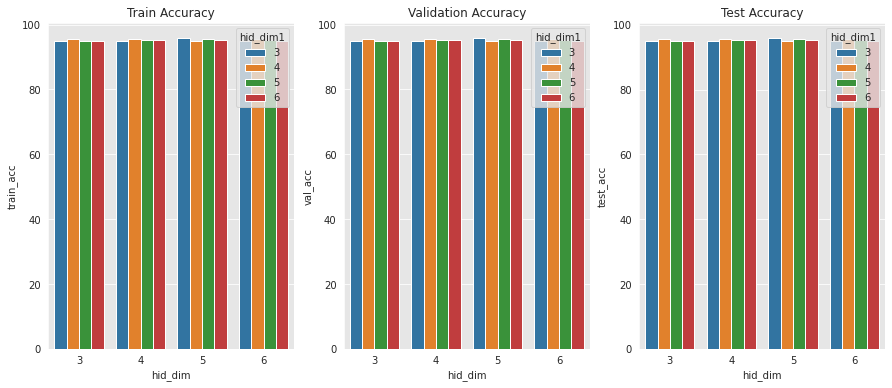

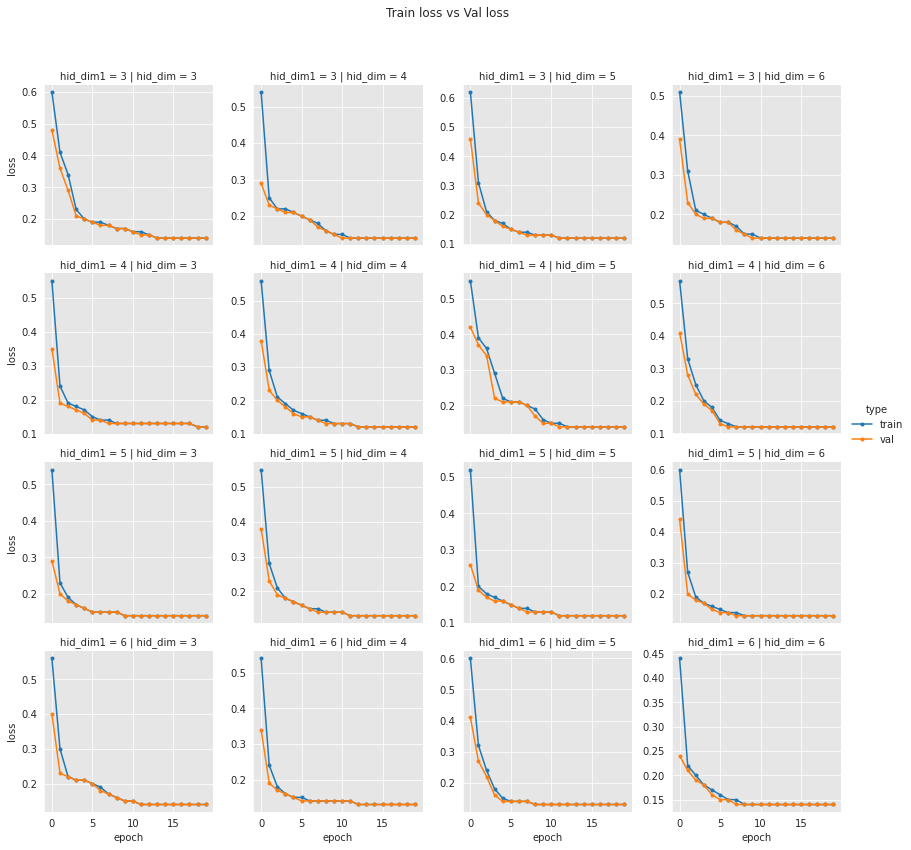

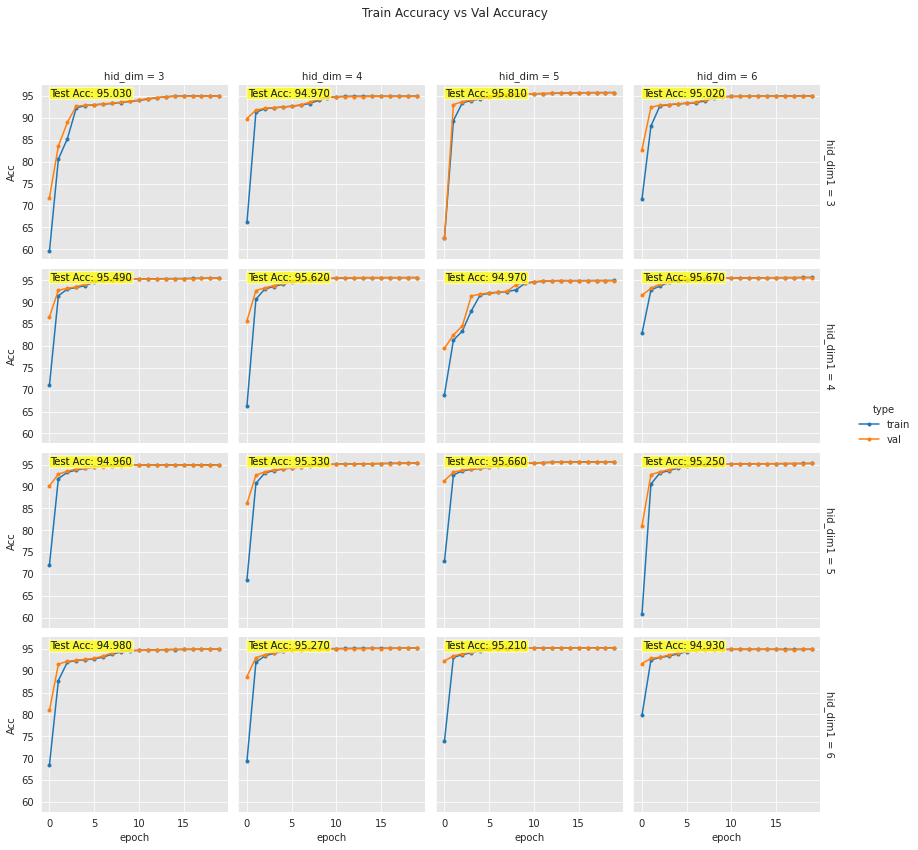

In [37]:
var1 = 'hid_dim'
var2 = 'hid_dim1'
df = load_exp_result('exp')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.